In [9]:
%matplotlib inline
import ultraplot as uplt
import matplotlib as plt

from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
#from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio.plot import show
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from shapely import wkt
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.transform import array_bounds
import rasterio.mask as rmask
from shapely import Polygon

import scale_bar

In [2]:
county_2019 = gpd.read_file('./Data/counties_2019.geojson')
county_2020 = gpd.read_file('./Data/counties_2020.geojson')
county_2021 = gpd.read_file('./Data/counties_2021.geojson')
county_2022 = gpd.read_file('./Data/counties_2022.geojson')

In [3]:
def expand(x):
    if x.geometry.geom_type == 'Polygon':
        return [x.geometry]
    else: 
        return [g for g in x.geometry.geoms]
        
county_2019["geometries"] = county_2019.apply(expand, axis=1)
county_2019 = county_2019.explode(column="geometries").drop(columns="geometry").set_geometry("geometries").rename_geometry("geometry")

county_2020["geometries"] = county_2020.apply(expand, axis=1)
county_2020 = county_2020.explode(column="geometries").drop(columns="geometry").set_geometry("geometries").rename_geometry("geometry")

county_2021["geometries"] = county_2021.apply(expand, axis=1)
county_2021 = county_2021.explode(column="geometries").drop(columns="geometry").set_geometry("geometries").rename_geometry("geometry")

county_2022["geometries"] = county_2022.apply(expand, axis=1)
county_2022 = county_2022.explode(column="geometries").drop(columns="geometry").set_geometry("geometries").rename_geometry("geometry")

In [4]:
# Load Imagery
mt_pleasant = rio.open('./Data/Study Regions/mt_pleasant_mean_condition.tif')
turkey_point = rio.open('./Data/Study Regions/turkey_point_mean_condition.tif')
arnot_forest = rio.open('./Data/Study Regions/arnot_forest_mean_condition.tif')
allegheny = rio.open('./Data/Study Regions/allegheny_mean_condition.tif')

In [5]:
alle_polygon = Polygon([[-79.09303776782116, 42.154449896225515],
          [-79.09303776782116, 41.754107496880174],
          [-78.64259831469616, 41.754107496880174],
          [-78.64259831469616, 42.154449896225515]])
mtp_polygon = Polygon([[-76.40060016519821, 42.47727532465593],
          [-76.40060016519821, 42.443208497007845],
          [-76.3556248844365, 42.443208497007845],
          [-76.3556248844365, 42.47727532465593]])

In [20]:
dest_crs = ccrs.AlbersEqualArea(central_longitude=-76.0, central_latitude=42.0,)

def prepare_for_viz(raster_file, dest_crs, mask_polygon=None):
    if mask_polygon is not None:
        orig_image, orig_transform = rmask.mask(raster_file, [mask_polygon], crop=True)
    else:
        orig_image = raster_file.read()
        orig_transform = raster_file.transform
        
    transform, width, height = calculate_default_transform(
        raster_file.crs, dest_crs, raster_file.width, raster_file.height, *raster_file.bounds)
    
    new_image, new_transform = reproject(
        source=orig_image,
        src_transform=orig_transform,
        src_crs=raster_file.crs,
        dst_crs=dest_crs,
        resampling=Resampling.nearest,
        dst_nodata=np.nan)
    print(new_transform)
    new_bounds = array_bounds(new_image.shape[1], new_image.shape[2], new_transform)
    new_image = new_image.transpose([1, 2, 0])
    print(np.nanpercentile(new_image, 95))
    new_image = np.clip(new_image / 1000, 0, 1)
    
    # Create a nan mask
    alpha_channel = ~np.isnan(new_image[:, :, [0]])
    new_image = np.concatenate([new_image, alpha_channel], axis=2)

    return new_image, new_bounds

mt_pleasant_reproj, mt_pleasant_reproj_bounds = prepare_for_viz(mt_pleasant, dest_crs, mask_polygon=mtp_polygon)
turkey_point_reproj, turkey_point_reproj_bounds = prepare_for_viz(turkey_point, dest_crs)
arnot_forest_reproj, arnot_forest_reproj_bounds = prepare_for_viz(arnot_forest, dest_crs)
allegheny_reproj, allegheny_reproj_bounds = prepare_for_viz(allegheny, dest_crs, mask_polygon=alle_polygon)

| 8.44, 0.00,-32033.83|
| 0.00,-8.44, 54636.25|
| 0.00, 0.00, 1.00|
913.3230769230769
| 8.11, 0.00,-365194.88|
| 0.00,-8.11, 82299.85|
| 0.00, 0.00, 1.00|
1035.2068181818177
| 8.07, 0.00,-54895.18|
| 0.00,-8.07, 34464.87|
| 0.00, 0.00, 1.00|
746.5285714285715
| 8.71, 0.00,-249634.71|
| 0.00,-8.71, 21388.09|
| 0.00, 0.00, 1.00|
731.741935483871


In [7]:
#### Helper function for creating insets
def create_inset_map(ax, loc, lonlim, latlim, bloc1, bloc2, image, image_bounds, origin_crs, scale_length, inset_label):
    """
    ax: parent axes for inset axes
    loc: location and size of inset axes (list of four elements, [x, y, width, height]
    lonlim: longitude limits of inset area (min, max)
    latlim: latitude limits of inset area (min, max)
    bloc1: border corner 1 for adding zoom effect
    bloc2: border corner 2 for adding zoom effect
    image: image to be displayed in inset axes as a numpy array
    image_bounds: bounds of image to be displyed in inset axes
    origin_crs: crs of image that is being added
    scale_length: length of scalebar
    inset_label: name of inset axes
    """
    # Create inset and zoom effect
    inset = ax.inset_axes(loc)
    inset.format(lonlim=lonlim, latlim=latlim,
                 color='black', linewidth=1)
    mark_inset(ax, inset, loc1=bloc1, loc2=bloc2, ec="black",ls= "solid", lw=1) # Proplot has issues with this apparently. Can be fixed by using mark_inset from Matplotlib
    
    # Add image to main axes
    ax.imshow(image, 
                 extent=[image_bounds[0], image_bounds[2], image_bounds[1], image_bounds[3]], 
                 origin='upper', transform=origin_crs, zorder=1)
    # Add image to inset axes and set extent
    inset.imshow(image, 
                 extent=[image_bounds[0], image_bounds[2], image_bounds[1], image_bounds[3]], 
                 origin='upper', transform=origin_crs)
    inset.set_extent([image_bounds[0], image_bounds[2], image_bounds[1], image_bounds[3]], crs=origin_crs)
    
    # Add scalebar
    scalebar = AnchoredSizeBar(inset.transData,
                           scale_length, f'{scale_length//1000} km', 'upper right', 
                           pad=0.3,
                           sep=3,
                           color='black',
                           frameon=True,
                           size_vertical=1,
                           label_top=True)
    inset.add_artist(scalebar)
    
    
    uplt.rc.titleweight = 'bold'
    inset.format(title=inset_label, titleloc='ul', titlebbox=True)
    
    return inset


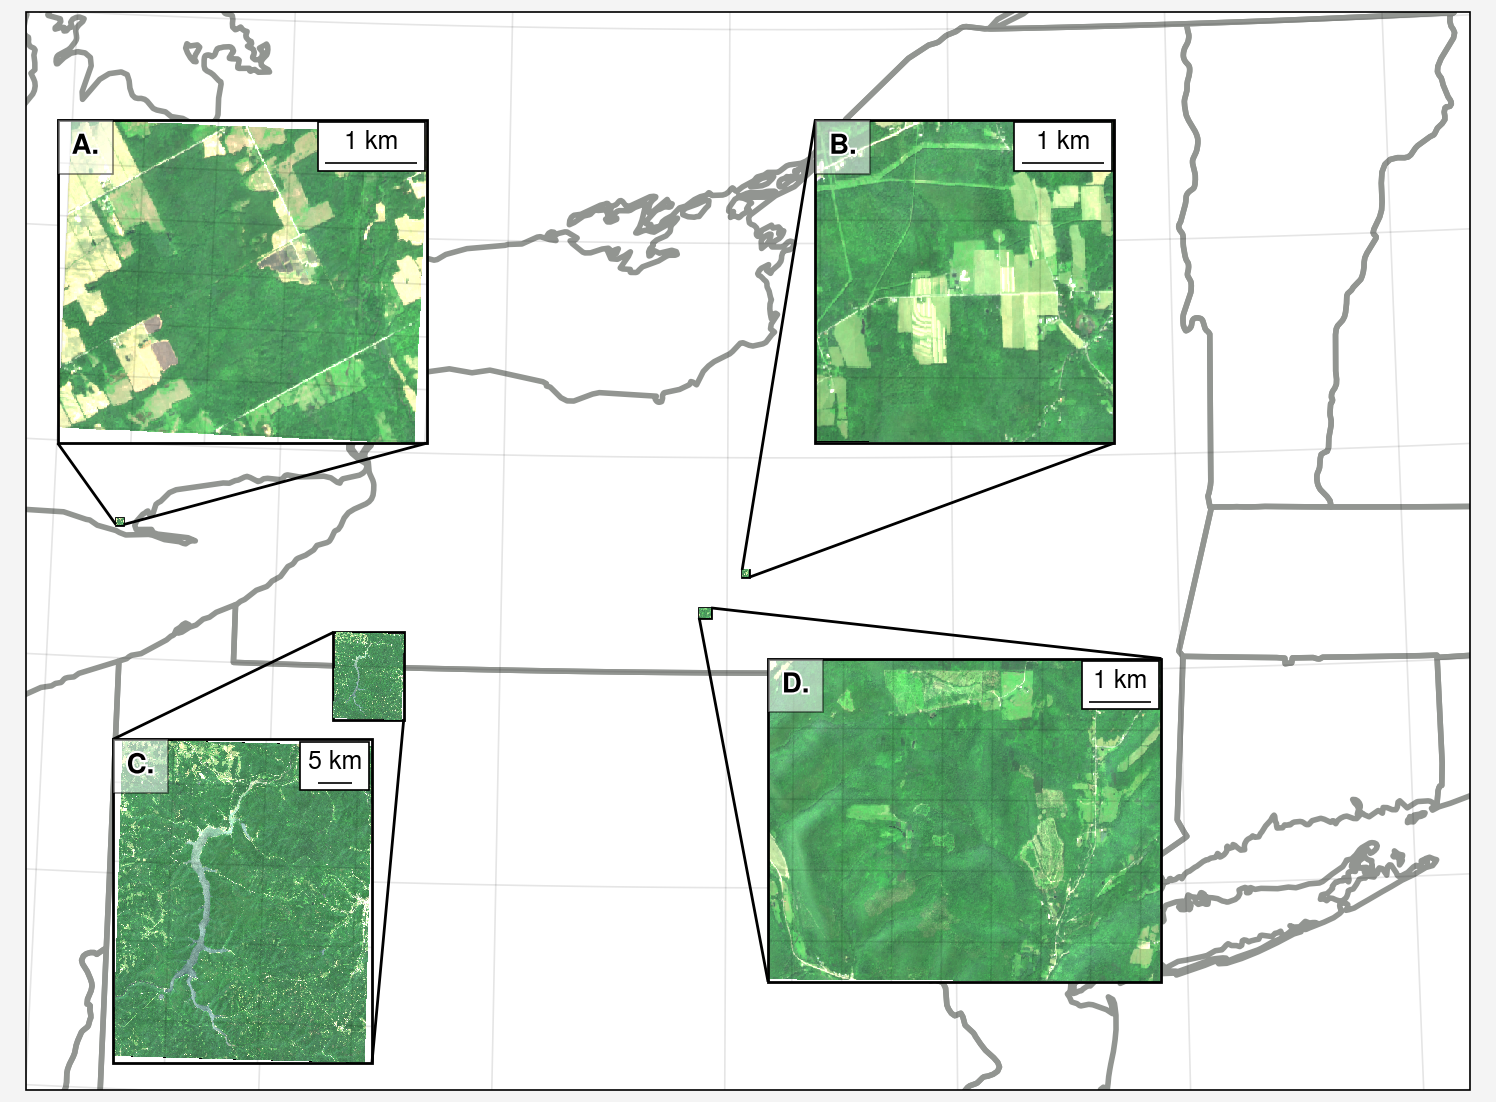

In [21]:
fig, axes = uplt.subplots(proj=dest_crs, figsize=('190mm', '140mm'))

# Need to grab axes out of SubplotGrid
ax = axes[0]

ax.set_extent([-81, -71.7, 40, 45], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=2, zorder=0)

# Create dummy data for prototyping inset plot
x = [0, 1, 2, 3, 4]
y = [3, 2, 3, 2, 3]

# Create inset plots
## Allegheny
allegheny_inset = create_inset_map(ax, [0, 0.025, 0.3, 0.3],
                                   (-79.1986092128225, -78.33343587297875), (41.72954071466429, 42.249085326281715),
                                   2, 4, allegheny_reproj, allegheny_reproj_bounds, dest_crs, 5000, 'C.')

## Mt. Pleasant
mt_pleasant_inset = create_inset_map(ax, [0.5, 0.6, 0.3, 0.3],
                                   (-76.40472618414064, -76.16963592840334), (42.3696708995445, 42.48029198346047),
                                   2, 4, mt_pleasant_reproj, mt_pleasant_reproj_bounds, dest_crs, 1000, 'B.')

## Arnot Forest
arnot_forest_inset = create_inset_map(ax, [0.5, 0.1, 0.3, 0.3],
                                   (-76.68476578221755, -76.60614487157302), (42.25466417545956, 42.29975344583736),
                                   1, 3, arnot_forest_reproj, arnot_forest_reproj_bounds, dest_crs, 1000, 'D.')

## Turkey Point
turkey_point_inset = create_inset_map(ax, [0, 0.6, 0.3, 0.3],
                                   (-80.57997293051788, -80.5315644222171), (42.61988855677763, 42.649124560997215),
                                   3, 4, turkey_point_reproj, turkey_point_reproj_bounds, dest_crs, 1000, 'A.')


fig.savefig('./Figures/Study Regions/all_sites.png')

In [12]:
def open_data(path):
    sample = pd.read_csv(path)
    sample = gpd.GeoDataFrame(
        sample, geometry=gpd.points_from_xy(sample.longitude, sample.latitude)
    )
    sample = sample[sample['combined'] != -1]

    return sample

In [13]:
alle_samples = open_data('./Data/site_validation/allegheny_validation.csv')
mtp_samples =open_data('./Data/site_validation/mt_pleasant_validation.csv')
af_samples = open_data('./Data/site_validation/arnot_forest_validation.csv')
tp_samples = open_data('./Data/site_validation/turkey_point_validation.csv')

In [18]:
def add_map(ax, image, bounds, crs):
    bounds_rearranged = [bounds[i] for i in [0, 2, 1, 3]] # Rasterio return bounds in different order than cartopy expects
    ax.imshow(image, extent=bounds_rearranged, 
              origin='upper', transform=crs)
    ax.set_extent(bounds_rearranged, crs=crs)

def add_sample_points(ax, samples):
    ax.scatter(samples['longitude'], samples['latitude'], ms=5, color='black', transform=ccrs.PlateCarree())

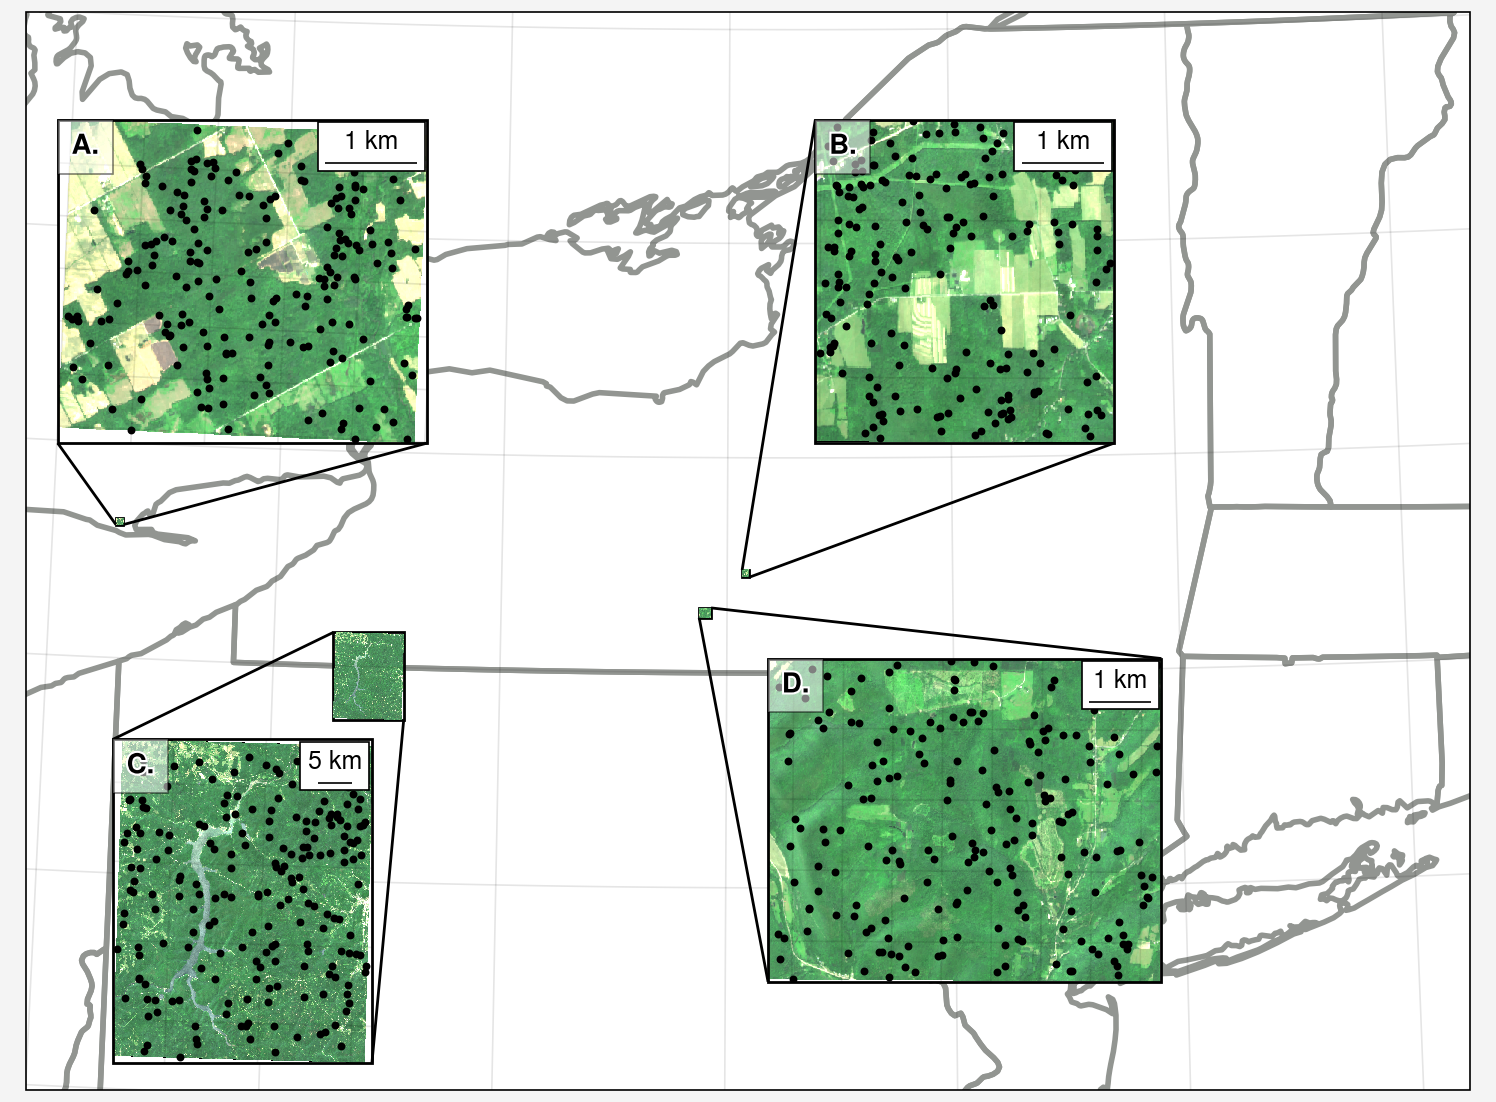

In [23]:
fig, axes = uplt.subplots(proj=dest_crs, figsize=('190mm', '140mm'))

# Need to grab axes out of SubplotGrid
ax = axes[0]

ax.set_extent([-81, -71.7, 40, 45], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=2, zorder=0)

# Create dummy data for prototyping inset plot
x = [0, 1, 2, 3, 4]
y = [3, 2, 3, 2, 3]

# Create inset plots
## Allegheny
allegheny_inset = create_inset_map(ax, [0, 0.025, 0.3, 0.3],
                                   (-79.1986092128225, -78.33343587297875), (41.72954071466429, 42.249085326281715),
                                   2, 4, allegheny_reproj, allegheny_reproj_bounds, dest_crs, 5000, 'C.')
add_sample_points(allegheny_inset, alle_samples)

## Mt. Pleasant
mt_pleasant_inset = create_inset_map(ax, [0.5, 0.6, 0.3, 0.3],
                                   (-76.40472618414064, -76.16963592840334), (42.3696708995445, 42.48029198346047),
                                   2, 4, mt_pleasant_reproj, mt_pleasant_reproj_bounds, dest_crs, 1000, 'B.')
add_sample_points(mt_pleasant_inset, mtp_samples)

## Arnot Forest
arnot_forest_inset = create_inset_map(ax, [0.5, 0.1, 0.3, 0.3],
                                   (-76.68476578221755, -76.60614487157302), (42.25466417545956, 42.29975344583736),
                                   1, 3, arnot_forest_reproj, arnot_forest_reproj_bounds, dest_crs, 1000, 'D.')
add_sample_points(arnot_forest_inset, af_samples)

## Turkey Point
turkey_point_inset = create_inset_map(ax, [0, 0.6, 0.3, 0.3],
                                   (-80.57997293051788, -80.5315644222171), (42.61988855677763, 42.649124560997215),
                                   3, 4, turkey_point_reproj, turkey_point_reproj_bounds, dest_crs, 1000, 'A.')
add_sample_points(turkey_point_inset, tp_samples)

fig.savefig('./Figures/Study Regions/all_sites_validation_points.png')

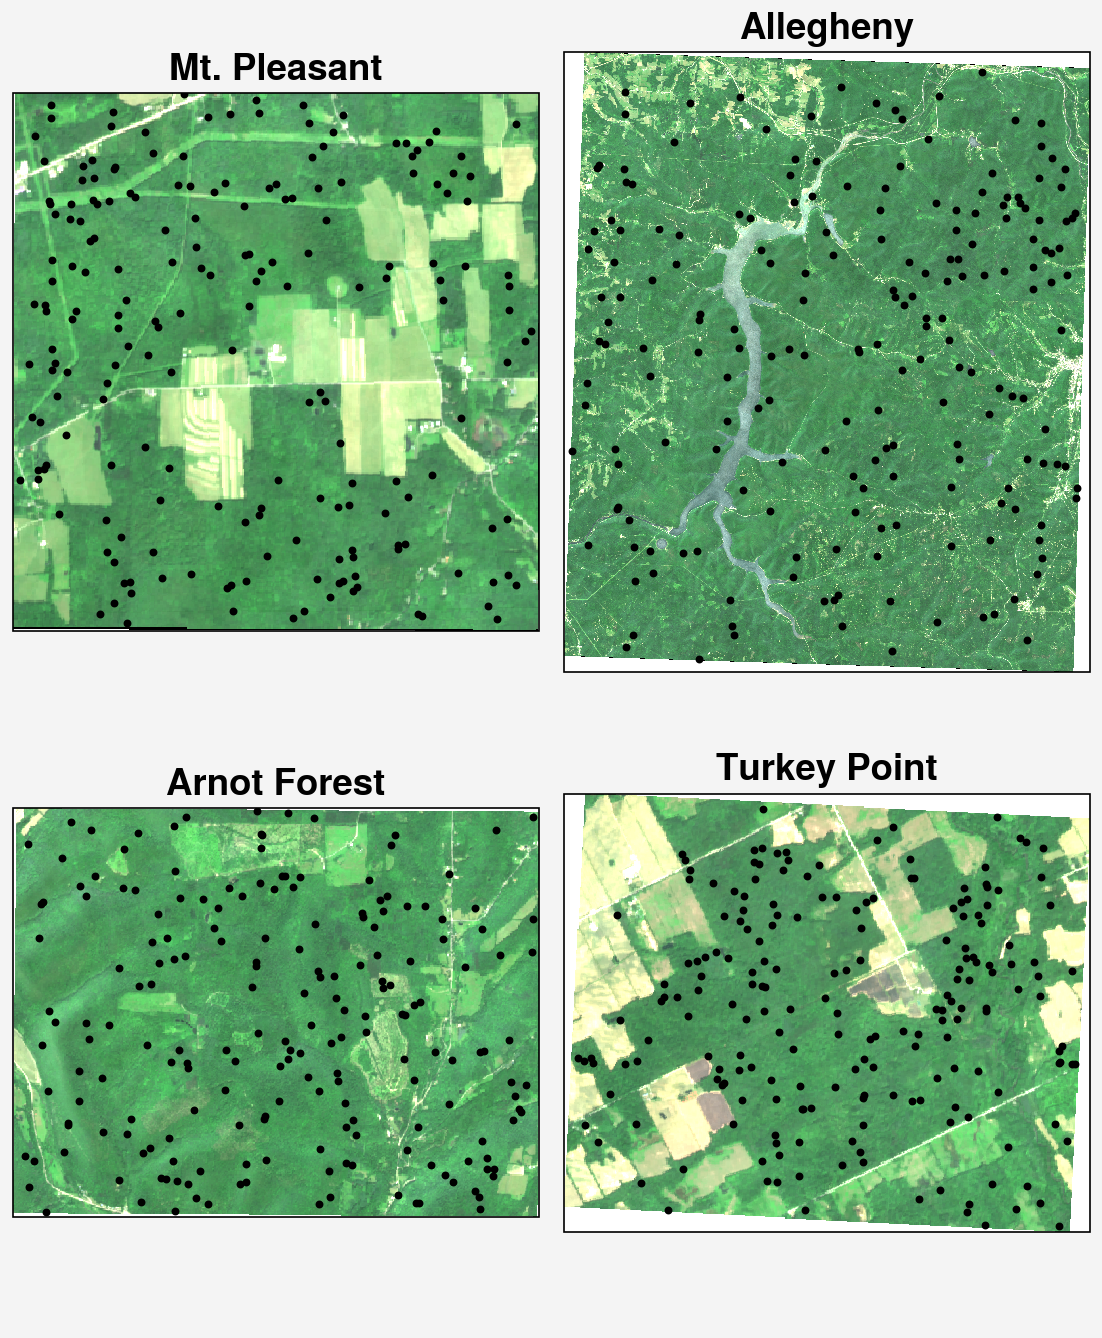

In [48]:
dest_crs = ccrs.LambertConformal(central_longitude=-76.0, central_latitude=42.0,)
fig, axes = uplt.subplots(nrows=2, ncols=2, proj=dest_crs, figsize=('140mm', '170mm'), fontsize=12)

add_map(axes[0], mt_pleasant_reproj, mt_pleasant_reproj_bounds, dest_crs)
add_sample_points(axes[0], mtp_samples)
axes[0].format(title='Mt. Pleasant')

add_map(axes[1], allegheny_reproj, allegheny_reproj_bounds, dest_crs)
add_sample_points(axes[1], alle_samples)
axes[1].format(title='Allegheny')

add_map(axes[2], arnot_forest_reproj, arnot_forest_reproj_bounds, dest_crs)
add_sample_points(axes[2], af_samples)
axes[2].format(title='Arnot Forest')

add_map(axes[3], turkey_point_reproj, turkey_point_reproj_bounds, dest_crs)
add_sample_points(axes[3], tp_samples)
axes[3].format(title='Turkey Point')

fig.savefig('./Figures/Study Regions/validation_points.png')

In [11]:
print(axes[0].transAxes.transform((-78, 42)))

[-19493.75        10993.21266968]


In [12]:
axes.transAxes

C:\Users\camer\AppData\Local\Temp\ipykernel_7420\2769020038.py:1: UltraPlotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axes.transAxes


(<matplotlib.transforms.BboxTransformTo at 0x254f0b3cb90>,
 <matplotlib.transforms.BboxTransformTo at 0x254f0b65a70>)